In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(1, "../..")
from simulations import laub_loomis
from itertools import product
from prototype_nn import Splitting, predictions, tensor_flatten
import matplotlib.pyplot as plt
import prototype
import torch
%run ../utilities.ipynb

## Training : Simulations

In [48]:
training = pd.DataFrame(data = pd.read_csv("../../data/train/laub.csv"))
training.head()

,time,x,y,z,w,p,q,m,initial_x,initial_y,initial_z,initial_w,initial_p,initial_q,initial_m
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,1,1
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,1,1,1,1,1,1,1
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,1,1,1,1,1,1,1
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,1,1,1,1,1,1,1
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,1,1,1,1,1,1,1


In [3]:
len(training)

640000

In [4]:
kfold = Splitting([0,8,9,10,11,12,13,14], [1,2,3,4,5,6,7], num_epoches = 5, batch_size = 32, lr= 0.00005)

In [107]:
evaluate = kfold.cross_validation_evaluate(training, 5)

------------- Fold 0 -------------
TEST: 0 TRAIN: [1, 2, 3, 4]
Epoch: 0  Train Loss: 0.0005632030661217868 
Epoch: 1  Train Loss: 0.00016792445967439562 
Epoch: 2  Train Loss: 0.00020622866577468812 
Epoch: 3  Train Loss: 0.0005936590023338795 
Epoch: 4  Train Loss: 2.636654426169116e-05 
------------- Fold 1 -------------
TEST: 1 TRAIN: [0, 2, 3, 4]
Epoch: 0  Train Loss: 0.00010425614163978025 
Epoch: 1  Train Loss: 0.00026528368471190333 
Epoch: 2  Train Loss: 0.00023547207820229232 
Epoch: 3  Train Loss: 5.427421456261072e-06 
Epoch: 4  Train Loss: 0.00032659564749337733 
------------- Fold 2 -------------
TEST: 2 TRAIN: [0, 1, 3, 4]
Epoch: 0  Train Loss: 3.843784725177102e-05 
Epoch: 1  Train Loss: 0.0005244789062999189 
Epoch: 2  Train Loss: 0.0006629665731452405 
Epoch: 3  Train Loss: 1.2621449059224688e-05 
Epoch: 4  Train Loss: 4.9928024964174256e-05 
------------- Fold 3 -------------
TEST: 3 TRAIN: [0, 1, 2, 4]
Epoch: 0  Train Loss: 0.0009734859922900796 
Epoch: 1  Train Loss

In [108]:
evaluate

[tensor(0.0001, grad_fn=<MseLossBackward>),
 tensor(0.0003, grad_fn=<MseLossBackward>),
 tensor(9.0856e-05, grad_fn=<MseLossBackward>),
 tensor(0.0001, grad_fn=<MseLossBackward>),
 tensor(0.0001, grad_fn=<MseLossBackward>)]

In [109]:
average_loss = 0
for x in evaluate:
    average_loss += x.item()
average_loss/len(evaluate)

0.0001710399446892552

In [5]:
training['initial_parameters'] = list(zip(training.initial_x, 
                                          training.initial_y,
                                          training.initial_z,
                                          training.initial_w,
                                          training.initial_p,
                                          training.initial_q,
                                          training.initial_m,))
training = training.drop(columns = ["initial_x","initial_y","initial_z","initial_w","initial_p","initial_q","initial_m"])
training.head()

,time,x,y,z,w,p,q,m,initial_parameters
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"(1, 1, 1, 1, 1, 1, 1)"
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,"(1, 1, 1, 1, 1, 1, 1)"
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,"(1, 1, 1, 1, 1, 1, 1)"
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,"(1, 1, 1, 1, 1, 1, 1)"
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,"(1, 1, 1, 1, 1, 1, 1)"


In [6]:
initial = training[training["initial_parameters"] == (1, 1, 1, 1, 1, 1, 1)]

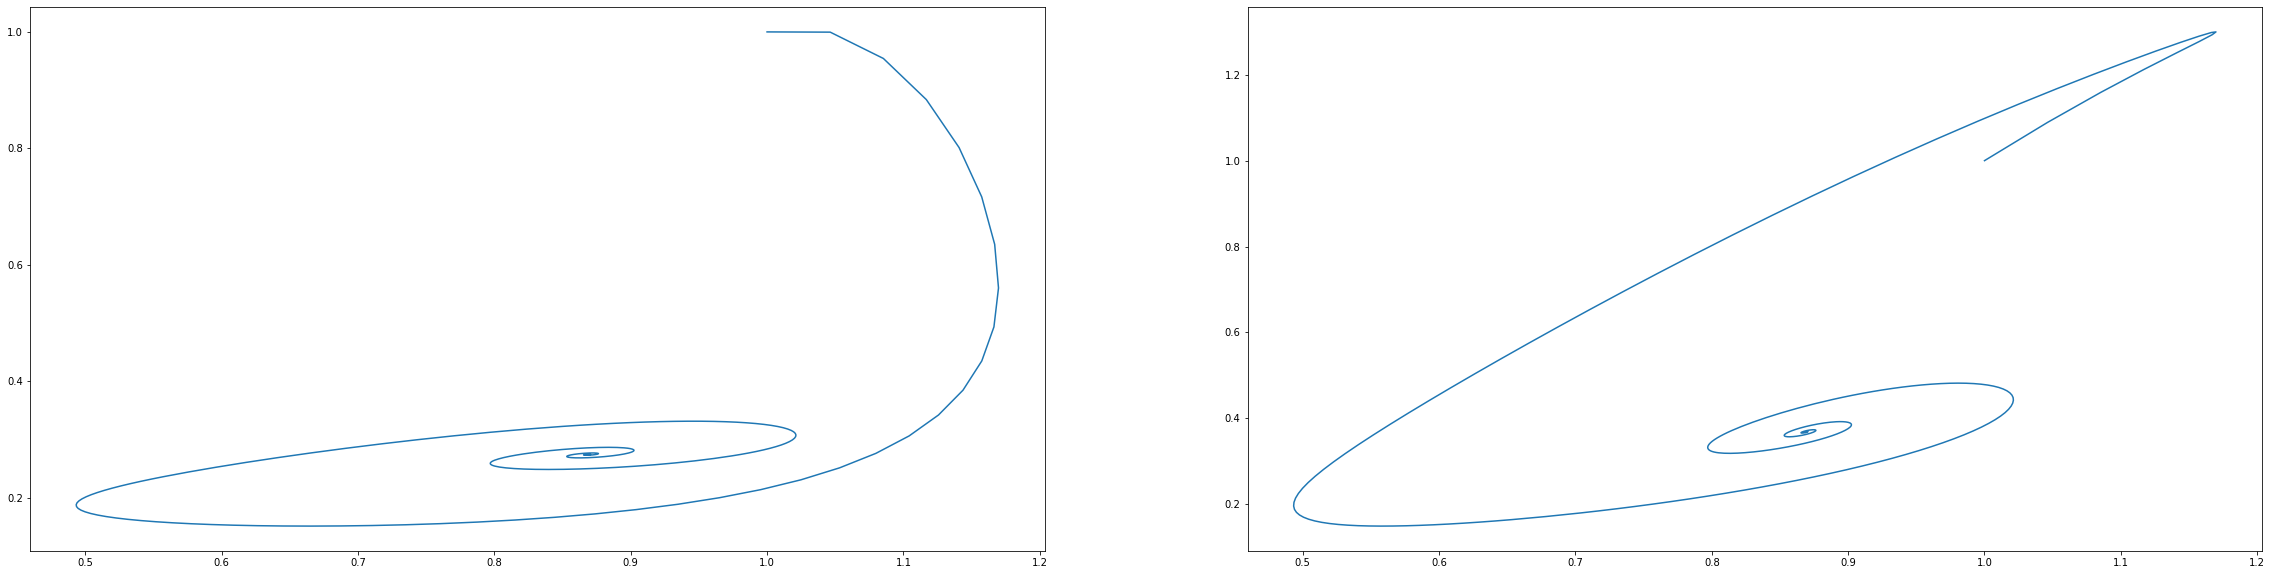

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(40,10))
ax[0].plot(initial[["x"]], initial[["m"]])
ax[1].plot(initial[["x"]], initial[["y"]])

## Training : Predictions

In [8]:
training_predictions = pd.DataFrame(data=pd.read_csv("../../data/train/laub.csv"))
training_predictions.head()

,time,x,y,z,w,p,q,m,initial_x,initial_y,initial_z,initial_w,initial_p,initial_q,initial_m
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1,1,1,1,1,1
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,1,1,1,1,1,1,1
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,1,1,1,1,1,1,1
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,1,1,1,1,1,1,1
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,1,1,1,1,1,1,1


In [9]:
training_predictions['initial_parameters'] = list(zip(training_predictions.initial_x, 
                                          training_predictions.initial_y,
                                          training_predictions.initial_z,
                                          training_predictions.initial_w,
                                          training_predictions.initial_p,
                                          training_predictions.initial_q,
                                          training_predictions.initial_m,))
training_predictions = training_predictions.drop(columns = ["initial_x","initial_y","initial_z","initial_w","initial_p","initial_q","initial_m"])
training_predictions = training_predictions.rename(columns = {"x" : "x_preds", 
                                           "y" : "y_preds",
                                           "z" : "z_preds",
                                           "w" : "w_preds",
                                           "p" : "p_preds",
                                           "q" : "q_preds",
                                           "m" : "m_preds"})
training_predictions.head()

,time,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds,initial_parameters
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"(1, 1, 1, 1, 1, 1, 1)"
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,"(1, 1, 1, 1, 1, 1, 1)"
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,"(1, 1, 1, 1, 1, 1, 1)"
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,"(1, 1, 1, 1, 1, 1, 1)"
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,"(1, 1, 1, 1, 1, 1, 1)"


In [10]:
training_and_predictions = pd.merge(training, training_predictions, right_on = ["time", "initial_parameters"],
                                    left_on = ["time", "initial_parameters"])

In [11]:
training_and_predictions.head()

,time,x,y,z,w,p,q,m,initial_parameters,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"(1, 1, 1, 1, 1, 1, 1)",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.1,1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591,"(1, 1, 1, 1, 1, 1, 1)",1.046344,1.089278,0.977479,1.067052,0.969840,0.759887,0.999591
2,0.2,1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383,"(1, 1, 1, 1, 1, 1, 1)",1.085316,1.159105,0.949473,1.129410,0.939626,0.584872,0.954383
3,0.3,1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737,"(1, 1, 1, 1, 1, 1, 1)",1.116813,1.212209,0.916103,1.188790,0.909574,0.457412,0.883737
4,0.4,1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426,"(1, 1, 1, 1, 1, 1, 1)",1.140811,1.250961,0.878194,1.246728,0.879699,0.364638,0.801426


In [12]:
initial = training_and_predictions[training_and_predictions["initial_parameters"] == (1, 1, 1, 1, 1, 1, 1)]

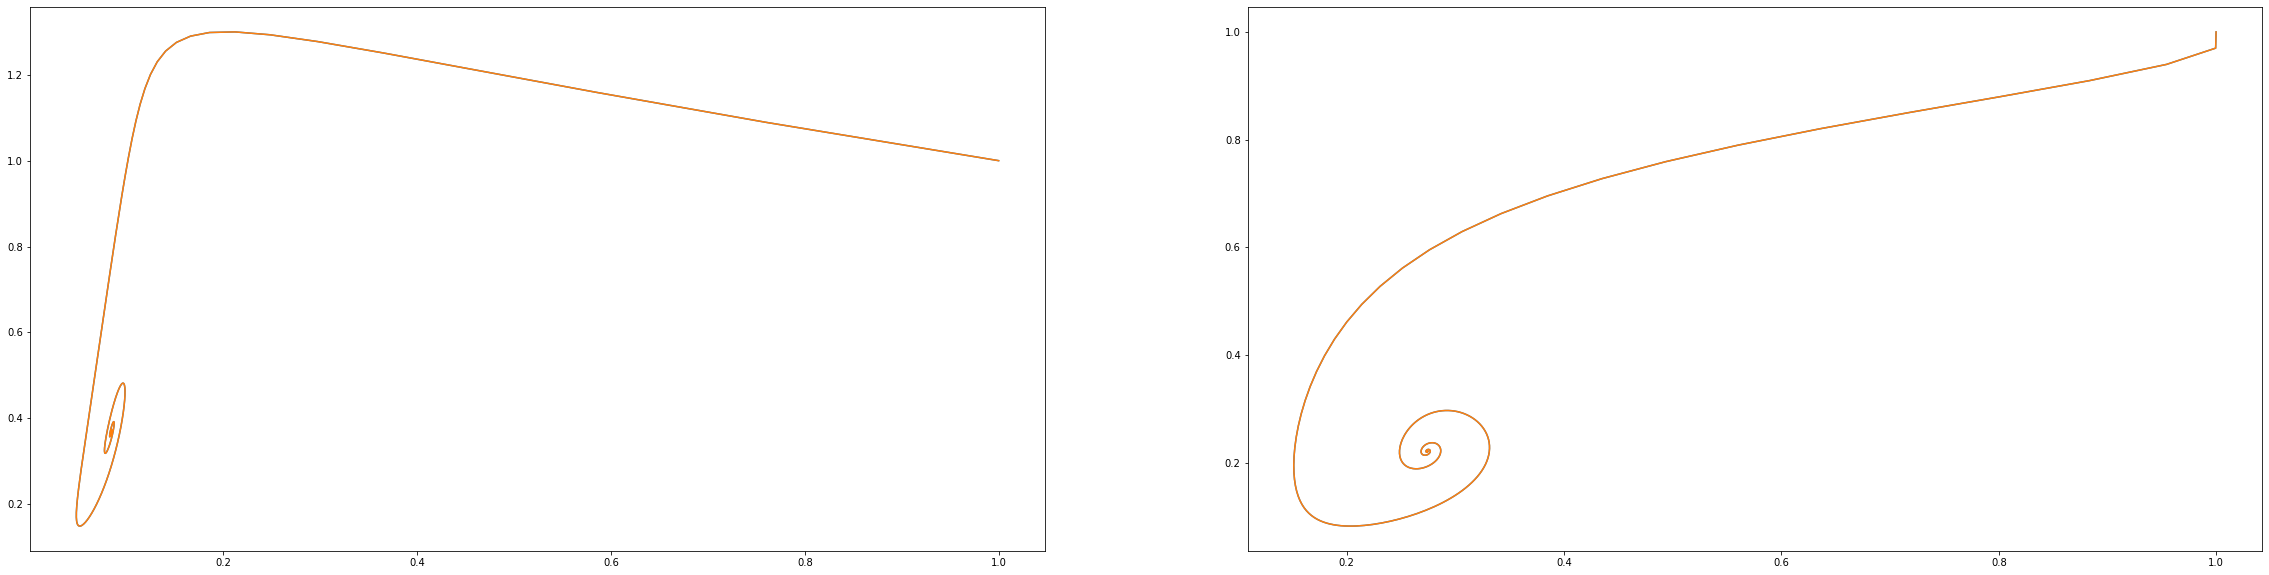

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(40,10))
ax[0].plot(initial[["q"]], initial[["y"]])
ax[0].plot(initial[["q_preds"]], initial[["y_preds"]])

ax[1].plot(initial[["m"]], initial[["p"]])
ax[1].plot(initial[["m_preds"]], initial[["p_preds"]])

## Testing : Simulations

In [123]:
testing = laub_loomis(delta = 0.1, simulations = 500, save = False, initial_paras = np.round(np.random.uniform(0, 5, 2), 2))
testing.head()

,time,x,y,z,w,p,q,m,initial_x,initial_y,initial_z,initial_w,initial_p,initial_q,initial_m
0,0.0,4.960000,4.960000,4.960000,4.960000,4.960000,4.960000,4.960000,4.96,4.96,4.96,4.96,4.96,4.96,4.96
1,0.1,5.091769,5.242356,3.472819,3.035906,3.673369,3.768101,2.830151,4.96,4.96,4.96,4.96,4.96,4.96,4.96
2,0.2,5.040123,5.295143,2.381879,2.252182,3.150658,2.894663,1.685965,4.96,4.96,4.96,4.96,4.96,4.96,4.96
3,0.3,4.870670,5.253846,1.626369,1.918830,2.878340,2.250989,1.076534,4.96,4.96,4.96,4.96,4.96,4.96,4.96
4,0.4,4.632202,5.167766,1.114943,1.793574,2.697675,1.773494,0.738745,4.96,4.96,4.96,4.96,4.96,4.96,4.96


In [124]:
len(testing)

640000

In [125]:
testing['initial_parameters'] = list(zip(testing.initial_x, 
                                          testing.initial_y,
                                          testing.initial_z,
                                          testing.initial_w,
                                          testing.initial_p,
                                          testing.initial_q,
                                          testing.initial_m,))

In [126]:
testing.head()

,time,x,y,z,w,p,q,m,initial_x,initial_y,initial_z,initial_w,initial_p,initial_q,initial_m,initial_parameters
0,0.0,4.960000,4.960000,4.960000,4.960000,4.960000,4.960000,4.960000,4.96,4.96,4.96,4.96,4.96,4.96,4.96,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
1,0.1,5.091769,5.242356,3.472819,3.035906,3.673369,3.768101,2.830151,4.96,4.96,4.96,4.96,4.96,4.96,4.96,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
2,0.2,5.040123,5.295143,2.381879,2.252182,3.150658,2.894663,1.685965,4.96,4.96,4.96,4.96,4.96,4.96,4.96,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
3,0.3,4.870670,5.253846,1.626369,1.918830,2.878340,2.250989,1.076534,4.96,4.96,4.96,4.96,4.96,4.96,4.96,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
4,0.4,4.632202,5.167766,1.114943,1.793574,2.697675,1.773494,0.738745,4.96,4.96,4.96,4.96,4.96,4.96,4.96,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"


In [127]:
def testing_preds(test_df):
    inputs = torch.tensor(test_df.iloc[ :, [0,8,9,10,11,12,13,14]].values)
    targets = torch.tensor(test_df.iloc[:, [1,2,3,4,5,6,7]].values)
    preds, _ = predictions(num_inputs=8, num_classes=7, learning_rate=0.0005, batch_size=1, num_epochs=1, inputs=inputs.float(), targets=targets.float(), train=False, path= "../../data/state/loomis.pth")
    data = {'time' : test_df.time.values,
            'initial_parameters' : test_df.initial_parameters.values,
            'x' : tensor_flatten(preds[:,0]), 'y' : tensor_flatten(preds[:, 1]), 
            'z' : tensor_flatten(preds[:, 2]), 'w' : tensor_flatten(preds[:, 3]),
            'p' : tensor_flatten(preds[:, 4]), 'q' : tensor_flatten(preds[:, 5]), 
            'm' : tensor_flatten(preds[:, 6])}
    return pd.DataFrame(data = data, columns = ["time", "x", "y", "z", "w", "p", "q", "m", "initial_parameters"]);

In [128]:
testing_predictions = testing_preds(testing)
testing_predictions.head()

,time,x,y,z,w,p,q,m,initial_parameters
0,0.0,3.657056,4.038548,2.394052,2.371751,3.899572,2.914239,3.083795,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
1,0.1,3.659647,4.100927,2.247164,2.366440,3.797363,2.721687,2.886241,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
2,0.2,3.660678,4.164036,2.097996,2.360999,3.693579,2.525955,2.685702,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
3,0.3,3.643948,4.228289,1.950037,2.368075,3.579919,2.337122,2.485600,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
4,0.4,3.624289,4.291857,1.801005,2.379358,3.462023,2.144855,2.281646,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"


In [129]:
testing = testing.drop(columns = ["initial_x","initial_y","initial_z","initial_w","initial_p","initial_q","initial_m"])
testing.head()

,time,x,y,z,w,p,q,m,initial_parameters
0,0.0,4.960000,4.960000,4.960000,4.960000,4.960000,4.960000,4.960000,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
1,0.1,5.091769,5.242356,3.472819,3.035906,3.673369,3.768101,2.830151,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
2,0.2,5.040123,5.295143,2.381879,2.252182,3.150658,2.894663,1.685965,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
3,0.3,4.870670,5.253846,1.626369,1.918830,2.878340,2.250989,1.076534,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
4,0.4,4.632202,5.167766,1.114943,1.793574,2.697675,1.773494,0.738745,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"


In [130]:
testing_predictions = testing_predictions.rename(columns = {"x" : "x_preds", 
                                           "y" : "y_preds",
                                           "z" : "z_preds",
                                           "w" : "w_preds",
                                           "p" : "p_preds",
                                           "q" : "q_preds",
                                           "m" : "m_preds"})
testing_predictions.head()

,time,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds,initial_parameters
0,0.0,3.657056,4.038548,2.394052,2.371751,3.899572,2.914239,3.083795,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
1,0.1,3.659647,4.100927,2.247164,2.366440,3.797363,2.721687,2.886241,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
2,0.2,3.660678,4.164036,2.097996,2.360999,3.693579,2.525955,2.685702,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
3,0.3,3.643948,4.228289,1.950037,2.368075,3.579919,2.337122,2.485600,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
4,0.4,3.624289,4.291857,1.801005,2.379358,3.462023,2.144855,2.281646,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"


In [131]:
testing_and_predictions = pd.merge(testing, testing_predictions, right_on = ["time", "initial_parameters"],
                                    left_on = ["time", "initial_parameters"])

In [132]:
testing_and_predictions.head()

,time,x,y,z,w,p,q,m,initial_parameters,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds
0,0.0,4.960000,4.960000,4.960000,4.960000,4.960000,4.960000,4.960000,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)",3.657056,4.038548,2.394052,2.371751,3.899572,2.914239,3.083795
1,0.1,5.091769,5.242356,3.472819,3.035906,3.673369,3.768101,2.830151,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)",3.659647,4.100927,2.247164,2.366440,3.797363,2.721687,2.886241
2,0.2,5.040123,5.295143,2.381879,2.252182,3.150658,2.894663,1.685965,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)",3.660678,4.164036,2.097996,2.360999,3.693579,2.525955,2.685702
3,0.3,4.870670,5.253846,1.626369,1.918830,2.878340,2.250989,1.076534,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)",3.643948,4.228289,1.950037,2.368075,3.579919,2.337122,2.485600
4,0.4,4.632202,5.167766,1.114943,1.793574,2.697675,1.773494,0.738745,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)",3.624289,4.291857,1.801005,2.379358,3.462023,2.144855,2.281646


In [164]:
initial = testing_and_predictions[testing_and_predictions["initial_parameters"] == (4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)]

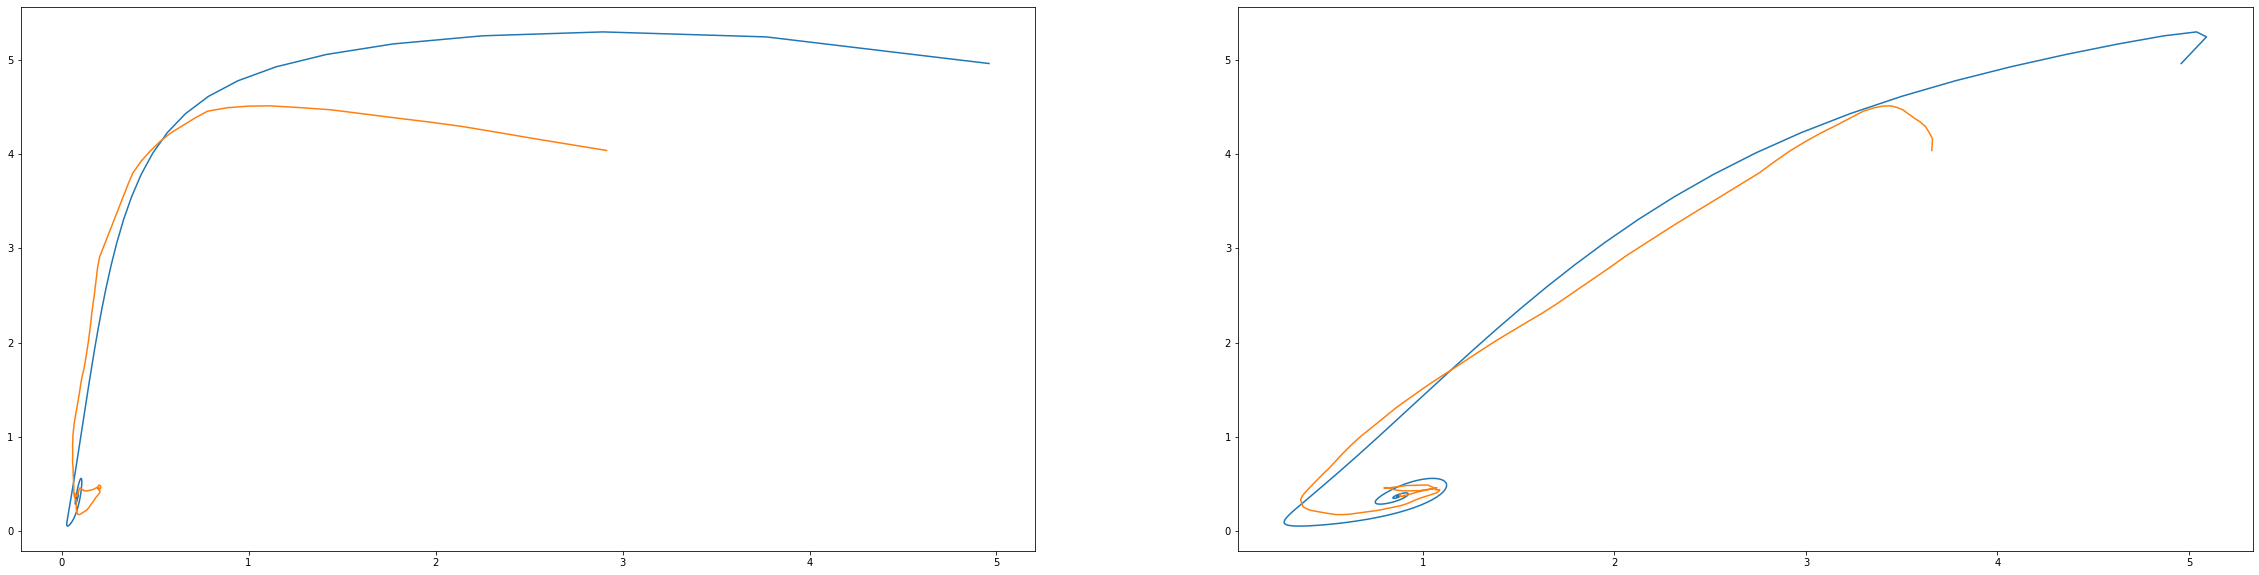

In [165]:
fig, ax = plt.subplots(ncols=2, figsize=(40,10))
ax[0].plot(initial[["q"]], initial[["y"]])
ax[0].plot(initial[["q_preds"]], initial[["y_preds"]])

ax[1].plot(initial[["x"]], initial[["y"]])
ax[1].plot(initial[["x_preds"]], initial[["y_preds"]])

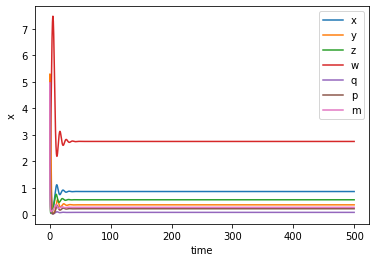

In [173]:
fig, ax = plt.subplots()
sns.lineplot(data = initial, x = "time", y = "x", ax = ax,label = "x")
sns.lineplot(data = initial, x = "time", y = "y", ax=ax, label = "y")
sns.lineplot(data = initial, x = "time", y = "z", ax=ax, label = "z")
sns.lineplot(data = initial, x = "time", y = "w", ax=ax, label = "w")
sns.lineplot(data = initial, x = "time", y = "q", ax=ax, label = "q")
sns.lineplot(data = initial, x = "time", y = "p", ax=ax, label = "p")
sns.lineplot(data = initial, x = "time", y = "m", ax=ax, label = "m")
ax.legend()

### Loss by simulation

This is caculating the loss by testing simulation. This goes through every simulation within the testing data and caculates the loss.

Below are the dataframes where using: 
<ol>
    <li>testing - holds the testing simulations</li>
    <li> testing_predictions - holds the predictions of the testing simulation </li>
</ol>

In [135]:
testing.head()

,time,x,y,z,w,p,q,m,initial_parameters
0,0.0,4.960000,4.960000,4.960000,4.960000,4.960000,4.960000,4.960000,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
1,0.1,5.091769,5.242356,3.472819,3.035906,3.673369,3.768101,2.830151,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
2,0.2,5.040123,5.295143,2.381879,2.252182,3.150658,2.894663,1.685965,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
3,0.3,4.870670,5.253846,1.626369,1.918830,2.878340,2.250989,1.076534,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
4,0.4,4.632202,5.167766,1.114943,1.793574,2.697675,1.773494,0.738745,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"


In [136]:
testing_predictions.head()

,time,x_preds,y_preds,z_preds,w_preds,p_preds,q_preds,m_preds,initial_parameters
0,0.0,3.657056,4.038548,2.394052,2.371751,3.899572,2.914239,3.083795,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
1,0.1,3.659647,4.100927,2.247164,2.366440,3.797363,2.721687,2.886241,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
2,0.2,3.660678,4.164036,2.097996,2.360999,3.693579,2.525955,2.685702,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
3,0.3,3.643948,4.228289,1.950037,2.368075,3.579919,2.337122,2.485600,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"
4,0.4,3.624289,4.291857,1.801005,2.379358,3.462023,2.144855,2.281646,"(4.96, 4.96, 4.96, 4.96, 4.96, 4.96, 4.96)"


This is going through a function which caculates the loss for each simulation

In [137]:
simulationLoss, _ = lossBySimulations(testing, testing_predictions, [1,2,3,4,5,6,7])

The dataframe it provides, we see each simulation (initial_parameters) corresponds to a loss

In [138]:
simulationLoss

,initial_parameters,Loss
0,3.79 3.79 3.79 3.79 3.79 3.79 3.79,0.014056
1,3.79 3.79 3.79 3.79 3.79 3.79 4.96,0.017738
2,3.79 3.79 3.79 3.79 3.79 4.96 3.79,0.031985
3,3.79 3.79 3.79 3.79 3.79 4.96 4.96,0.032672
4,3.79 3.79 3.79 3.79 4.96 3.79 3.79,0.013713
...,...,...
123,4.96 4.96 4.96 4.96 3.79 4.96 4.96,0.049768
124,4.96 4.96 4.96 4.96 4.96 3.79 3.79,0.023351
125,4.96 4.96 4.96 4.96 4.96 3.79 4.96,0.028129
126,4.96 4.96 4.96 4.96 4.96 4.96 3.79,0.041953


This function shows the plotted dataframe on the bar graph

In [139]:
initial_values = [np.arange(1,3,1),np.arange(1,3,1),np.arange(1,3,1),np.arange(1,3,1),np.arange(1,3,1),np.arange(1,3,1),np.arange(1,3,1)]

In [140]:
simulationLossDistance = lossBySimulationsDistance(simulationLoss, initial_values)

In [141]:
simulationLossDistance.head()

,initial_parameters,Loss,Distance
0,3.79 3.79 3.79 3.79 3.79 3.79 3.79,0.014056,12.070114
64,4.96 3.79 3.79 3.79 3.79 3.79 3.79,0.020641,13.129639
32,3.79 4.96 3.79 3.79 3.79 3.79 3.79,0.017528,13.129639
16,3.79 3.79 4.96 3.79 3.79 3.79 3.79,0.025859,13.129639
8,3.79 3.79 3.79 4.96 3.79 3.79 3.79,0.009673,13.129639


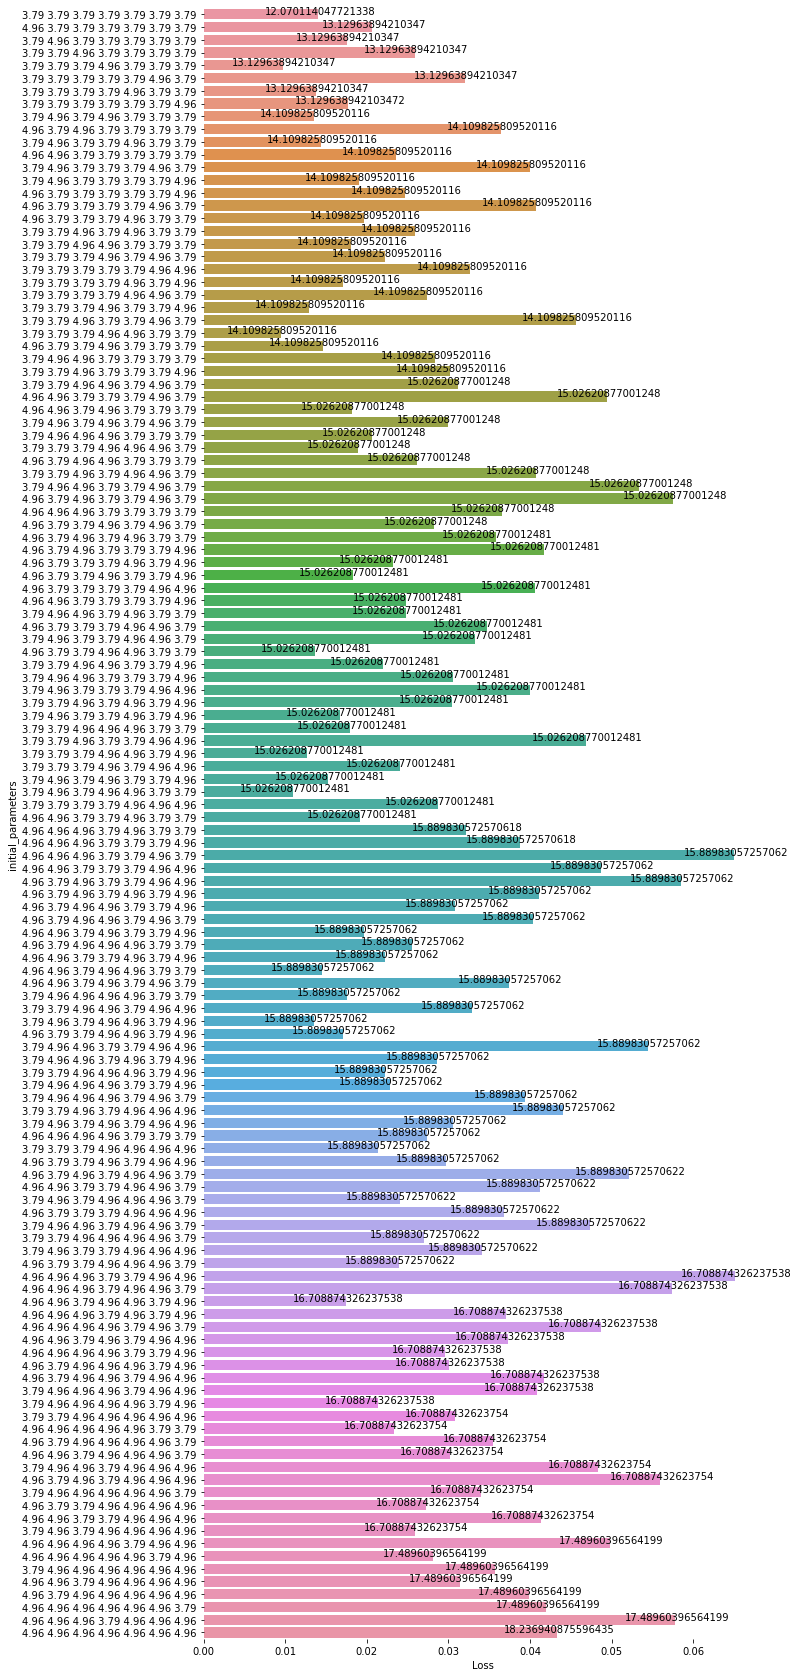

In [142]:
simulaPlots("Loss", "initial_parameters", simulationLossDistance, figsize = (20,40), pos = 0.2)

In [143]:
simulationSameDistance = simulationLossDistance.groupby("Distance").filter(lambda x: len(x) > 1).reset_index(drop = True)
simulationAverage = simulationSameDistance.groupby("Distance").mean("Loss").reset_index()
simulationMin = simulationSameDistance.groupby("Distance").min("Loss").reset_index()
simulationMax = simulationSameDistance.groupby("Distance").max("Loss").reset_index()

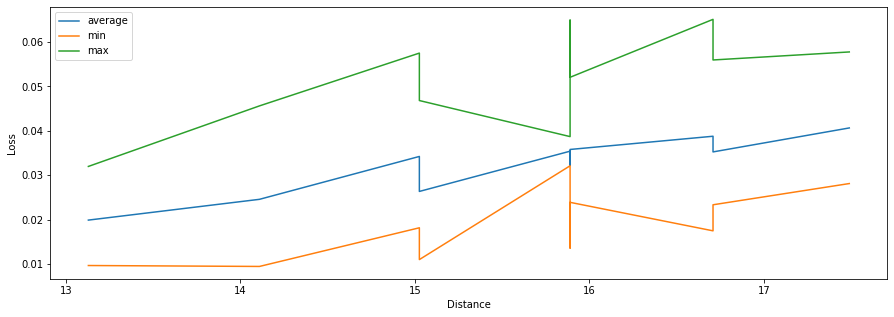

In [144]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data = simulationAverage, x = "Distance", y = "Loss", ax = ax, label = "average")
sns.lineplot(data = simulationMin, x = "Distance", y = "Loss", ax = ax, label = "min")
sns.lineplot(data = simulationMax, x = "Distance", y = "Loss", ax = ax, label = "max")
ax.legend()

This is going through a function which allows us to see the loss for each individual time within the dataframe

In [145]:
timeLoss, _ = lossByTime(testing, testing_predictions, [1,2,3,4,5,6,7])

This returns a dataframe shown below

In [146]:
timeLoss.head()

,Time,initial_parameters,Loss
0,0.0,"(3.79, 3.79, 3.79, 3.79, 3.79, 3.79, 3.79)",1.382125
1,0.1,"(3.79, 3.79, 3.79, 3.79, 3.79, 3.79, 3.79)",0.393788
2,0.2,"(3.79, 3.79, 3.79, 3.79, 3.79, 3.79, 3.79)",0.260707
3,0.3,"(3.79, 3.79, 3.79, 3.79, 3.79, 3.79, 3.79)",0.301522
4,0.4,"(3.79, 3.79, 3.79, 3.79, 3.79, 3.79, 3.79)",0.333812


In [147]:
individualTimeLoss = timeLoss.groupby("Time").mean("Loss").reset_index()

In [148]:
individualTimeLoss.head()

,Time,Loss
0,0.0,2.529828
1,0.1,0.701020
2,0.2,0.472280
3,0.3,0.527170
4,0.4,0.577762


This is the graph of the simulation

<AxesSubplot:xlabel='Time', ylabel='Loss'>

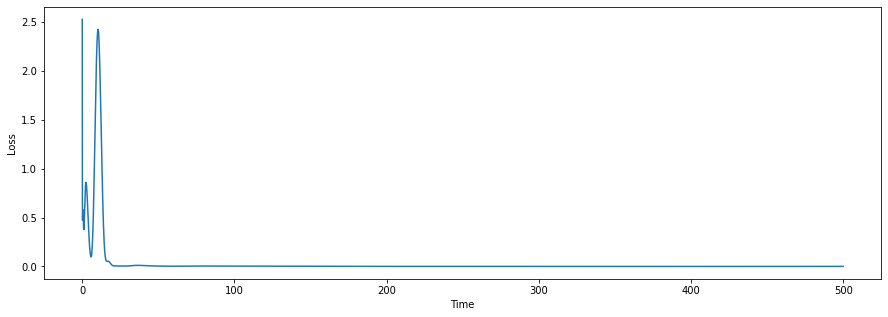

In [149]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data = individualTimeLoss, x = "Time", y = "Loss", ax = ax)

<AxesSubplot:>

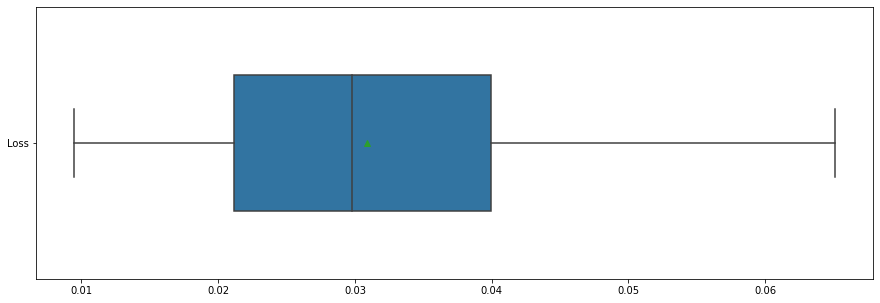

In [150]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data = simulationLossDistance[["Loss"]], showmeans=True, orient="h", width = 0.5, ax=ax)

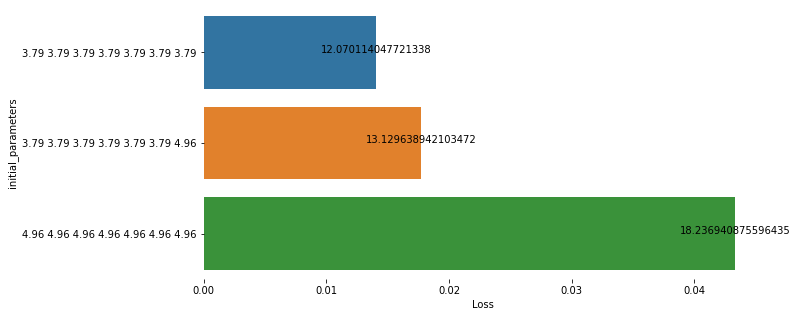

In [151]:
simulaPlots("Loss", "initial_parameters", simulationLossDistance.groupby("Distance").filter(lambda x: len(x) == 1), figsize = (10,5),  pos = 0.000005)